# Preparing Tokyo weather station data

In [10]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/GSOD/merged_cities/TOKYO.csv")

In [3]:
df

,Unnamed: 0,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,TEMP,TEMP_ATTRIBUTES,DEWP,...,MXSPD,GUST,MAX,MAX_ATTRIBUTES,MIN,MIN_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNDP,FRSHTT
0,0,47662099999,1990-01-01,35.683333,139.766667,36.0,"TOKYO, JA",41.1,8,17.1,...,5.1,999.9,49.6,,34.5,,0.00,I,999.9,0
1,1,47662099999,1990-01-02,35.683333,139.766667,36.0,"TOKYO, JA",42.4,8,23.2,...,9.9,999.9,48.9,,33.3,,0.00,I,999.9,0
2,2,47662099999,1990-01-03,35.683333,139.766667,36.0,"TOKYO, JA",42.5,8,21.1,...,9.9,999.9,48.4,,36.3,,0.00,I,999.9,0
3,3,47662099999,1990-01-04,35.683333,139.766667,36.0,"TOKYO, JA",42.0,8,14.7,...,15.0,999.9,48.7,,36.1,*,0.00,I,999.9,0
4,4,47662099999,1990-01-05,35.683333,139.766667,36.0,"TOKYO, JA",43.7,8,22.1,...,8.9,999.9,51.1,,34.2,*,0.00,I,999.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10510,10510,47662099999,2019-11-14,35.683333,139.766667,36.0,"TOKYO, JA",59.1,24,40.9,...,11.1,999.9,72.1,,50.4,*,0.02,G,999.9,0
10511,10511,47662099999,2019-11-15,35.683333,139.766667,36.0,"TOKYO, JA",53.7,23,44.2,...,7.0,999.9,62.8,,46.2,*,0.00,G,999.9,0
10512,10512,47662099999,2019-11-16,35.683333,139.766667,36.0,"TOKYO, JA",55.8,24,42.0,...,6.0,999.9,66.0,,46.0,,0.00,G,999.9,0
10513,10513,47662099999,2019-11-17,35.683333,139.766667,36.0,"TOKYO, JA",56.6,24,37.6,...,11.1,999.9,67.5,,46.8,,0.00,G,999.9,0


In [4]:
# drop old index column
df.drop(["Unnamed: 0"], axis=1, inplace=True)

# drop redundant column swith info about weather station
df.drop(["STATION", "LATITUDE", "LONGITUDE", "ELEVATION", "NAME"], axis=1, inplace=True)

# drop "attributes"
df.drop(["TEMP_ATTRIBUTES", "DEWP_ATTRIBUTES", "SLP_ATTRIBUTES", "STP_ATTRIBUTES", 
         "VISIB_ATTRIBUTES", "WDSP_ATTRIBUTES", "MAX_ATTRIBUTES", "MIN_ATTRIBUTES", "PRCP_ATTRIBUTES"], 
        axis=1, inplace=True)

# drop redundant weather info (max speed of wind, maximum wind gust, min and max temperature, snow depth,  
# indicator for occurrence of: fog, rain or drizzle, snow or ice pellets, hail, thunder, 
# tornado/funnel cloud respectively )
df.drop(["MXSPD", "GUST", "MAX", "MIN", "SNDP", "FRSHTT"], axis=1, inplace=True)

In [5]:
df.head()

,DATE,TEMP,DEWP,SLP,STP,VISIB,WDSP,PRCP
0,1990-01-01,41.1,17.1,1015.8,999.9,21.7,4.0,0.0
1,1990-01-02,42.4,23.2,1015.1,999.9,13.2,5.8,0.0
2,1990-01-03,42.5,21.1,1010.9,999.9,19.4,7.5,0.0
3,1990-01-04,42.0,14.7,1017.1,999.9,25.6,10.5,0.0
4,1990-01-05,43.7,22.1,1019.3,999.9,15.5,5.9,0.0


In [6]:
df.set_index([pd.to_datetime(df.DATE)], inplace=True)
df.drop(["DATE"], axis=1, inplace=True)

In [7]:
df.head()

,TEMP,DEWP,SLP,STP,VISIB,WDSP,PRCP
DATE,,,,,,,
1990-01-01,41.1,17.1,1015.8,999.9,21.7,4.0,0.0
1990-01-02,42.4,23.2,1015.1,999.9,13.2,5.8,0.0
1990-01-03,42.5,21.1,1010.9,999.9,19.4,7.5,0.0
1990-01-04,42.0,14.7,1017.1,999.9,25.6,10.5,0.0
1990-01-05,43.7,22.1,1019.3,999.9,15.5,5.9,0.0


__Missing data handling__

In [8]:
df.isna().sum()

TEMP     0
DEWP     0
SLP      0
STP      0
VISIB    0
WDSP     0
PRCP     0
dtype: int64

As we can see, there are no nans in the data

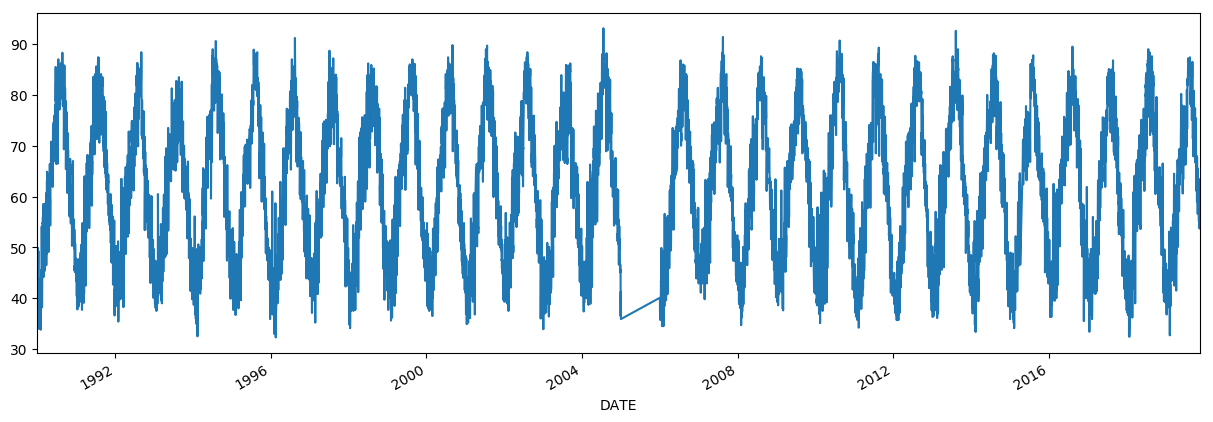

In [11]:
df.TEMP.plot()

There are no weather data for 2005 year, so lets impute it

In [12]:
# returns mean value for exact day of a year
def column_mean(df, column, date):
    total = 0
    all_years = [day for day in df.index if str(date)[4:] in str(day)]
    
    for year in all_years:
        total += df.at[year, column]
    
    return total / len(all_years)

In [13]:
# creates data for whole year, using mean value imputation
def create_missing_year(df, year):
    dates = pd.date_range(start='1/1/' + str(year), end='1/1/' + str(year + 1))[:-1]
    missing_data = dict()
    
    for col in df.columns:
        missing_data[col] = []
        
    for col in df.columns:
        for date in dates:
            missing_data[col].append(column_mean(df, col, date))
    
    missing_data = pd.DataFrame(data=missing_data, index=dates)
    
    return missing_data

In [14]:
# inserts missing year to dataset
def insert_year(df, year_df,  year):
    all_years = [str(date)[:4] for date in df.index if "-01-01" in str(date)]
    previous_year = str(year)
    while not previous_year in all_years:
        previous_year = str(int(previous_year) - 1)
    
    last_day = [date for date in df.index if previous_year in str(date)][-1]
    
    first_part = df.loc[:last_day, :]
    second_part = df.loc[last_day:,:][1:]
    
    return pd.concat([first_part, year_df, second_part])

In [15]:
missing_year =  create_missing_year(df, 2005)

In [16]:
missing_year

,TEMP,DEWP,SLP,STP,VISIB,WDSP,PRCP
2005-01-01,43.934483,22.986207,1014.331034,113.089655,15.768966,5.934483,3.460000
2005-01-02,43.893103,25.237931,1014.355172,182.162069,15.424138,5.117241,3.448966
2005-01-03,43.655172,23.989655,1014.024138,78.396552,14.672414,5.413793,3.457586
2005-01-04,43.913793,22.062069,1014.855172,148.106897,17.006897,6.555172,0.065172
2005-01-05,43.589655,23.375862,1016.462069,115.227586,14.872414,5.958621,0.015172
...,...,...,...,...,...,...,...
2005-12-27,44.500000,23.967857,1016.135714,118.835714,13.835714,6.160714,0.050357
2005-12-28,44.567857,24.307143,1015.982143,154.150000,12.085714,5.878571,3.595714
2005-12-29,44.339286,25.342857,1015.760714,82.500000,12.832143,5.417857,0.060714
2005-12-30,44.464286,24.989286,1015.250000,189.021429,12.882143,5.678571,3.628929


In [17]:
df = insert_year(df, missing_year, 2005)

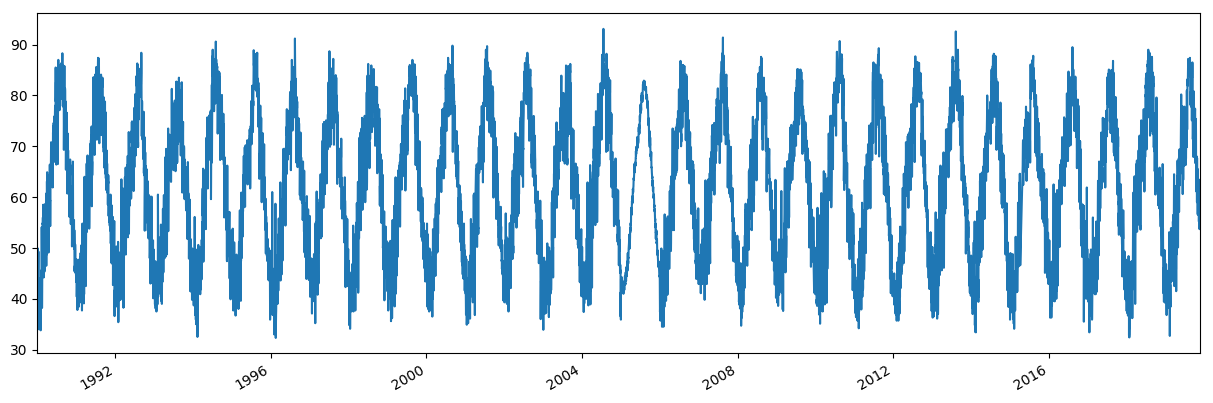

In [18]:
df.TEMP.plot()

Now, there are no missing data for all years

In [19]:
df.describe()

,TEMP,DEWP,SLP,STP,VISIB,WDSP,PRCP
count,10880.000000,10880.000000,10880.000000,10880.000000,10880.000000,10880.000000,10880.000000
mean,61.904013,48.732665,1013.762628,136.937211,9.989993,6.106836,3.129207
std,14.143442,97.211309,6.706077,324.431018,21.835436,2.015990,16.642612
min,32.300000,0.500000,983.800000,0.000000,0.800000,2.000000,0.000000
25%,48.900000,32.400000,1009.200000,6.900000,5.400000,4.700000,0.000000
50%,62.687931,49.700000,1013.600000,11.800000,8.856897,5.700000,0.000000
75%,73.400000,64.000000,1018.400000,18.500000,12.400000,7.000000,0.150000
max,93.100000,9999.900000,1035.900000,999.900000,999.900000,19.200000,99.990000


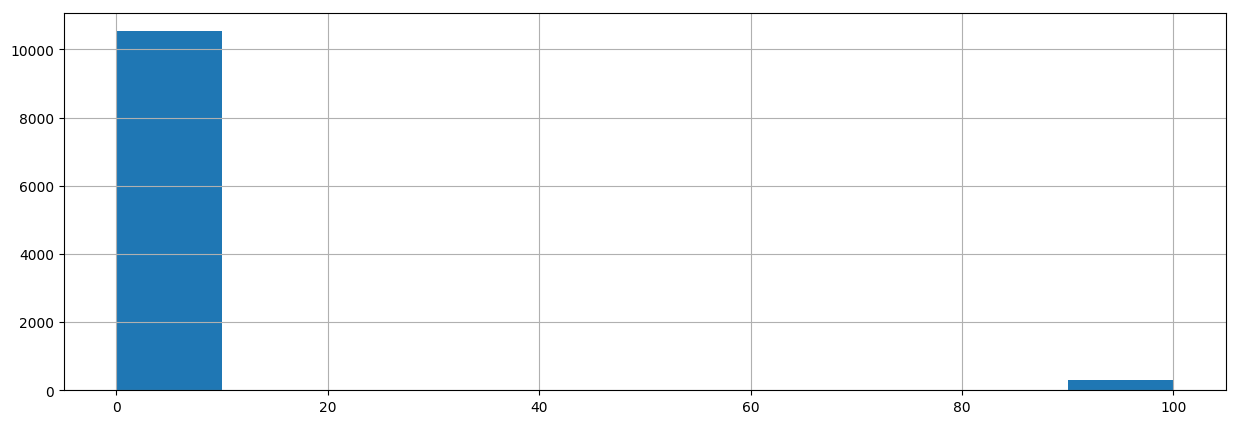

In [26]:
df.PRCP.hist()

In [25]:
df.PRCP.value_counts()

0.000000     6607
0.020000      351
99.990000     311
0.030000      223
0.040000      219
             ... 
0.238966        1
3.651724        1
7.094828        1
3.611034        1
3.568276        1
Name: PRCP, Length: 600, dtype: int64

In [ ]:
df.to_csv("../analysis/Tokyo.csv")